In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [3]:
#Use bilinear interpolation to resize images to 64 square
size = 64
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size),
    torchvision.transforms.ToTensor()
])

#load dataset and init dataloader
mnist_dset_train = torchvision.datasets.MNIST(root = './data/MNIST/', download=True, train = True, transform = transform)
batch_size = 128
mnist_DL = torch.utils.data.DataLoader(mnist_dset_train, shuffle=True, batch_size=batch_size)

In [4]:
#convert labels to one-hot
def to_oneHot(x, num_classes = 10):
    size = x.shape[0]
    x = x.view(size,1,1)
    return torch.zeros(size, num_classes,1).scatter(1,x,1)

Images: torch.Size([128, 1, 64, 64])
Labels: torch.Size([128])


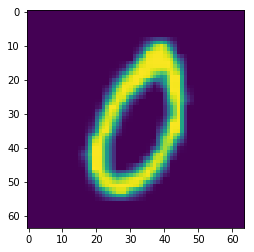

In [5]:
#show sample
sample = next(iter(mnist_DL))
print('Images:', sample[0].shape)
print('Labels:', sample[1].shape)
plt.imshow(sample[0][0,0])

In [48]:
#num features
nf = 64

#use GPU if available 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#Build convolutional neural network
class MNIST_classifier(nn.Module):
    def __init__(self):
        super(MNIST_classifier, self).__init__() #init MNIST_classifier's superclass
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, nf, 4, 2, 1), #out 32
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf, nf*2, 4, 2, 1), #out 16
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf*2, nf*4, 4, 2, 1), #out 8
            nn.BatchNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf*4, nf*2, 4, 2, 1), #out 4
            nn.BatchNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf*2, nf, 4, 2, 1), #out 2
            nn.BatchNorm2d(nf),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.lin = nn.Sequential(
            nn.Linear(nf*4, 10),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, nf*4)
        return self.lin(x)


In [8]:
#initialize and test network
net = MNIST_classifier().to(device)
net(sample[0].to(device)).shape

torch.Size([128, 10])

In [9]:
#initialize error function and optimizer
opt = torch.optim.Adam(net.parameters(), betas=(0.5, 0.999), lr = 0.01)
error = torch.nn.BCELoss()

In [10]:
#training parameters
epochs = 5
iters = 0
iters_cycle = 100

#save losses
losses = []

#train
for epoch in range(epochs):
    #iterate through dataloader
    for batch in mnist_DL:
        #separate batch into labels and images
        images = batch[0].to(device)
        labels = batch[1]
        
        #convert labels to one-hot
        labels = to_oneHot(labels).to(device)[:,:,0]
        
        #make predictions
        pred = net(images)
        
        #calculate loss
        loss = error(pred, labels)
        
        #backpropagate gradients with Adam algorithm
        loss.backward()
        opt.step()
        
        #set gradients to zero
        net.zero_grad()
        
        #save losses
        losses.append(loss.item())
        
        #log progress
        if iters%iters_cycle==0:    
            print('Epoch: {}/{}     Iter: {}     Loss: {}'.format(epoch, epochs, iters, loss.item()))
        iters +=1

Epoch: 0/5     Iter: 0     Loss: 0.6914423108100891
Epoch: 0/5     Iter: 100     Loss: 0.020476361736655235
Epoch: 0/5     Iter: 200     Loss: 0.011427117511630058
Epoch: 0/5     Iter: 300     Loss: 0.010736871510744095
Epoch: 0/5     Iter: 400     Loss: 0.02653830125927925
Epoch: 1/5     Iter: 500     Loss: 0.021647626534104347
Epoch: 1/5     Iter: 600     Loss: 0.004777188412845135
Epoch: 1/5     Iter: 700     Loss: 0.008201416581869125
Epoch: 1/5     Iter: 800     Loss: 0.0020560026168823242
Epoch: 1/5     Iter: 900     Loss: 0.0029505742713809013
Epoch: 2/5     Iter: 1000     Loss: 0.008588855154812336
Epoch: 2/5     Iter: 1100     Loss: 0.0056138308718800545
Epoch: 2/5     Iter: 1200     Loss: 0.003575171111151576
Epoch: 2/5     Iter: 1300     Loss: 0.006421943195164204
Epoch: 2/5     Iter: 1400     Loss: 0.007238081656396389
Epoch: 3/5     Iter: 1500     Loss: 0.0029742345213890076
Epoch: 3/5     Iter: 1600     Loss: 0.008843369781970978
Epoch: 3/5     Iter: 1700     Loss: 0.0135

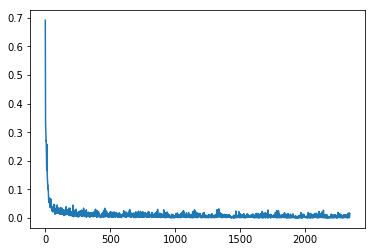

In [11]:
#plot loss curve 
plt.plot(losses)

In [1]:
#Evaluate accuracy using one-hot encoded predictions
def testAccuracy(model, test_set, cpu = 'False'):
    #set device
    if cpu == True:
        dev = torch.device('cpu')
    else:
        dev = torch.device('cuda:0')
    model = model.to(dev)
    test_images = test_set[0].to(dev)
    test_labels = test_set[1].to(dev)
    
    #make predictions
    with torch.no_grad(): 
        model_pred = model(test_images).cpu().numpy() 
        
    #Count number of correct predictions    
    correct = 0
    total = test_labels.shape[0]
    for i, prediction in enumerate(model_pred):
        if test_labels[i]==np.argmax(prediction):
            correct += 1
            
    #revert model to global device
    model=model.to(device)
    
    #print accuracy
    return print('Accuracy across {} samples: {}%'.format(test_labels.shape[0], correct/total*100))

In [63]:
#Create test dataset and load into dataloader
mnist_dset_test = torchvision.datasets.MNIST(root = './data/MNIST/', download=True, train = False, transform = transform)
num_samples = 10000
mnist_DL_test = torch.utils.data.DataLoader(mnist_dset_test, shuffle=True, batch_size=num_samples)

#Evaluate accuracy on test set
test_set= next(iter(mnist_DL_test))
testAccuracy(net, test_set, cpu = True)

Accuracy across 10000 samples: 98.9%


Label: 7
Prediction: 7


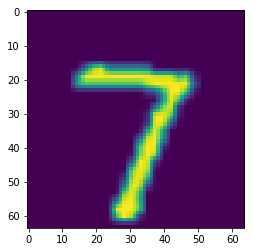

In [64]:
#display sample with label and prediction
sample = next(iter(mnist_DL))
print('Label:', sample[1][0].item())
print('Prediction:', torch.argmax(net(sample[0].to(device))[0]).item())
plt.imshow(sample[0][0,0])